# Ch 06 게이트가 추가된 RNN

## 6.1 RNN의 문제점 
- RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어렵다. 
- 이유: BPTT에서 기울기 소실 혹은 폭발이 일어난다.

## 6.1.2 Gradient Vansih or Gradient Explode 
## 6.1.3 원인
- 아래 코드는 MatMul 노드를 지날때 역전파의 기울기를 나타내는 것이다. 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [19]:
N = 2 # 미니배치의 크기
H = 3 #은닉상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이
dh  = np.ones((N,H))
np.random.seed(3) # 재현가능 하도록 난수의 seed 고정
#Wh = np.random.randn(H,H)  # 변경전
Wh = np.random.randn(H,H) * 0.5 # 변경 후

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]
20


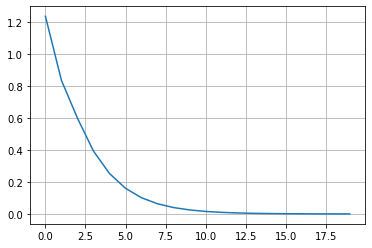

In [20]:
print(norm_list)
print(T)
plt.plot(range(20), norm_list)
plt.grid()

- 위와 같이 크기는 시간에 비례해 지수적으로 증가한다. [ Gradient Explode ] 
- 시간에 비례하여 기울기가 지수적으로 감소한다. [ Gradient Vanish ] 

- Wh: 스칼라일때
    - 1 초과시 explode. 1 미만시 vanish
- Wh: 행렬일때
    - 특이값(보통 최댓값을봄)을 기주으로 1보다 큰지의 여부에 따라 기울기가 결정된다. 

## 6.1.4 Gradient Explode 의 대책 
- 고전 기법: gradient clipping
        - if ||g|| > threshold: 
            g = thresold / ||g|| *g 
- ||g|| 는 기울기의 L2 norm
- g: 신경망에서 사용되는 모든 매개변수의 기울기를 하나로 모은것. ex) W1, W2를 사용 > dW1, dW2를 결합한것을 g
- 아래의 코드는 gradient clipping을 구현

In [37]:
dW1 = np.random.rand(3,3) *10 
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    print(total_norm)
    rate = max_norm /(total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
        print(grad)

In [38]:
print(grads)
clip_grads(grads, max_norm) # total_norm 과 grad 출력 해봄

[array([[9.71624297, 3.67702983, 2.04939769],
       [2.4057032 , 8.27862801, 9.65228149],
       [6.98809998, 4.82497042, 2.87049765]]), array([[8.33687884, 8.72179508, 0.92131592],
       [2.15949471, 8.3176109 , 8.48303897],
       [3.14652999, 2.79294597, 4.30815022]])]
26.238534230314368
[[1.58867078 1.66202019 0.17556543]
 [0.41151205 1.58499909 1.61652297]
 [0.59960092 0.53222216 0.8209586 ]]


# 6.2 기울기 소실과 LSTM(Long Short Term Memory)

## 6.2.1 LSTM의 interface 
- RNN과의 가장 큰 차이점은 c 라는 memory cell이 있는것이다. (LSTM 전용 기억 메커니즘)
- memory cell : 데이터를 LSTM 계층 내에서만 주고 받는다는 것. > 다른 계층으로 출력하지 않는다.

## 6.2.2 LSTM 계층 조립하기 
 - ct 에서는 과거로부터 시각 t 까지에 필요한 모든 정보다 저장되어 있다고 가정.
 
 ## 6.2.3 output gate 
 - 각 원소 대해 그것이 다음 시각의 은닉 상태에 얼마나 중요한가를 조정 
 - output gate의 열린정도는 xt, h(t-1)로부터 구한다. 
    - o = sigmoid(xtWx + h(t-1)Wh + b)
    - ht = o O tanh(ct). 
    - Hadamard product( 원소별 곱셈 ) 

## 6.2.4 forget gate 
- c(t-1)이 가지고있는것 중 불필요한것을 없앤다. 
    - f = sigmoid(xtWx + h(t-1)Wh + b)
- 이 f 와 이전의 memory cell인 c(t-1)과 아다마르 곱을 계산하면 ct 가 된다. 

## 6.2.5 새로운 기억 셀
- forget gate를 거치면서 이적 기억셀로부터 잊어야 할 기억이 삭제. 
- 새로 기억해야 할 정보 추가한다. 
    - g = tanh(xtWx + h(t-1)Wh + b)

## 6.2.6 input gate
- g 의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다. 
    - i = sigmoid(xtWx + h(t-1)Wh + b) 

# 6.3 LSTM 구현

- Affine Transformation : 아래 식의 반복되는 부분을 한번에 계산한다. (행렬변환과 편행이동 사용)

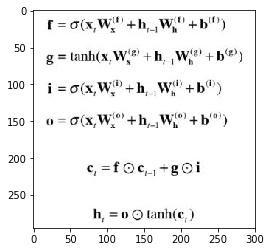

In [42]:
i = imread('LSTM.jpg')
plt.imshow(i)
plt.show()

이를 바탕으로 아래는 LSTM 클래스의 구현이다. 

In [3]:
class LSTM:
    # 초기화부분
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
        

## 6.3.1 Time LSTM
- T개의 시계열 데이터를 한꺼번에 처리하는 계층이다. 

In [4]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

# 6.4 LSTM을 사용한 언어모델

In [5]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

In [7]:
# 신경망을 이용하여 PTB데이터셋 학습.
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb



# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

Done
| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 10003.46
| 에폭 1 |  반복 21 / 1327 | 시간 16[s] | 퍼플렉서티 2889.49
| 에폭 1 |  반복 41 / 1327 | 시간 30[s] | 퍼플렉서티 1231.74
| 에폭 1 |  반복 61 / 1327 | 시간 44[s] | 퍼플렉서티 974.85
| 에폭 1 |  반복 81 / 1327 | 시간 60[s] | 퍼플렉서티 773.40
| 에폭 1 |  반복 101 / 1327 | 시간 76[s] | 퍼플렉서티 670.54
| 에폭 1 |  반복 121 / 1327 | 시간 95[s] | 퍼플렉서티 644.75
| 에폭 1 |  반복 141 / 1327 | 시간 108[s] | 퍼플렉서티 596.27
| 에폭 1 |  반복 161 / 1327 | 시간 121[s] | 퍼플렉서티 579.05
| 에폭 1 |  반복 181 / 1327 | 시간 134[s] | 퍼플렉서티 572.69
| 에폭 1 |  반복 201 / 1327 | 시간 147[s] | 퍼플렉서티 496.75
| 에폭 1 |  반복 221 / 1327 | 시간 160[s] | 퍼플렉서티 496.97
| 에폭 1 |  반복 241 / 1327 | 시간 173[s] | 퍼플렉서티 435.17
| 에폭 1 |  반복 261 / 1327 | 시간 187[s] | 퍼플렉서티 462.99
| 에폭 1 |  반복 281 / 1327 | 시간 200[s] | 퍼플렉서티 449.26
| 에폭 1 |  반복 301 / 1327 | 시간 212[s] | 퍼플렉서티 382.79
| 에폭 1 |  반복 321 / 1327 | 시간 227[s] | 퍼플렉서티 347.49
| 에폭 1 |  반복 341 / 1327 | 시간 241[s] | 퍼플렉서티 405.22
| 에폭 1 |  반복 361 / 1327 | 시간 256[s] | 퍼플렉서티 405.42
| 에폭 1 |  반복 381 / 1327 | 시간 267[s] 

| 에폭 3 |  반복 501 / 1327 | 시간 2156[s] | 퍼플렉서티 129.51
| 에폭 3 |  반복 521 / 1327 | 시간 2169[s] | 퍼플렉서티 137.22
| 에폭 3 |  반복 541 / 1327 | 시간 2180[s] | 퍼플렉서티 136.28
| 에폭 3 |  반복 561 / 1327 | 시간 2197[s] | 퍼플렉서티 118.98
| 에폭 3 |  반복 581 / 1327 | 시간 2210[s] | 퍼플렉서티 105.92
| 에폭 3 |  반복 601 / 1327 | 시간 2225[s] | 퍼플렉서티 149.55
| 에폭 3 |  반복 621 / 1327 | 시간 2237[s] | 퍼플렉서티 142.94
| 에폭 3 |  반복 641 / 1327 | 시간 2250[s] | 퍼플렉서티 128.47
| 에폭 3 |  반복 661 / 1327 | 시간 2265[s] | 퍼플렉서티 119.72
| 에폭 3 |  반복 681 / 1327 | 시간 2280[s] | 퍼플렉서티 99.72
| 에폭 3 |  반복 701 / 1327 | 시간 2293[s] | 퍼플렉서티 119.10
| 에폭 3 |  반복 721 / 1327 | 시간 2306[s] | 퍼플렉서티 125.85
| 에폭 3 |  반복 741 / 1327 | 시간 2319[s] | 퍼플렉서티 107.19
| 에폭 3 |  반복 761 / 1327 | 시간 2332[s] | 퍼플렉서티 103.07
| 에폭 3 |  반복 781 / 1327 | 시간 2345[s] | 퍼플렉서티 105.27
| 에폭 3 |  반복 801 / 1327 | 시간 2361[s] | 퍼플렉서티 114.89
| 에폭 3 |  반복 821 / 1327 | 시간 2375[s] | 퍼플렉서티 117.94
| 에폭 3 |  반복 841 / 1327 | 시간 2387[s] | 퍼플렉서티 115.06
| 에폭 3 |  반복 861 / 1327 | 시간 2400[s] | 퍼플렉서티 120.94
| 에폭 3 |  반복 

KeyboardInterrupt: 